# pyiron_workflow concepts

In [1]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow
from pyiron_workflow.function import function_node

CPU times: user 615 ms, sys: 208 ms, total: 823 ms
Wall time: 1.31 s


## Phonopy example

In [2]:
%%time
wf = Workflow('phonopy')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')

CPU times: user 1.69 s, sys: 671 ms, total: 2.36 s
Wall time: 3.45 s


In [3]:
wf = Workflow('test')
wf.structure = wf.create.atomistic.structure.build.Bulk('Al')

In [4]:
@Workflow.wrap.as_macro_node("structure")
def BulkRotation(wf, name='Al', cubic: bool=True, repeat_cell=2, angle=0, axis=(0,0,1)):
    wf.structure = wf.create.atomistic.structure.build.Bulk(
        name=name, 
        cubic=cubic
    )
    wf.repeat = wf.create.atomistic.structure.transform.Repeat(
        structure=wf.structure, 
        repeat_scalar=repeat_cell
    )
    wf.rotate = wf.create.atomistic.structure.transform.RotateAxisAngle(
        structure=wf.repeat, 
        angle=angle, axis=axis
    )
    return wf.rotate

In [5]:
br = BulkRotation()
br.structure.inputs.name.value, br.structure.inputs.cubic.value

('Al', True)

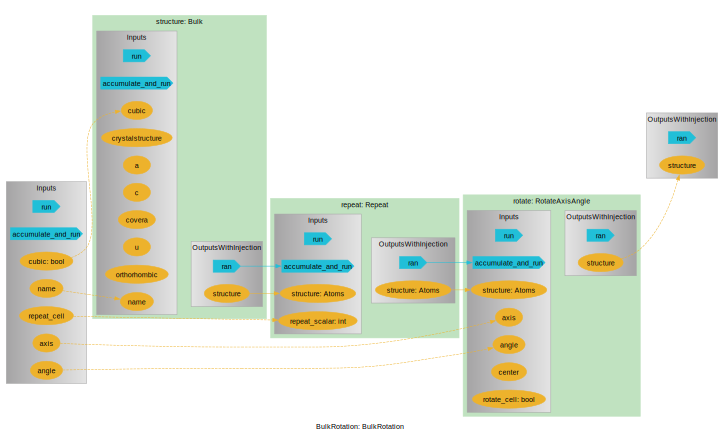

In [6]:
br.draw(size=(10, 10))

In [7]:
br.inputs.name

In [8]:
br = BulkRotation(name='Fe')
br.structure.inputs.name = 'Al'
br.inputs.name = 'Al'
br.run()

{'structure': Al: [0. 0. 0.]
 Al: [0.    2.025 2.025]
 Al: [2.025 0.    2.025]
 Al: [2.025 2.025 0.   ]
 Al: [0.   0.   4.05]
 Al: [0.    2.025 6.075]
 Al: [2.025 0.    6.075]
 Al: [2.025 2.025 4.05 ]
 Al: [0.   4.05 0.  ]
 Al: [0.    6.075 2.025]
 Al: [2.025 4.05  2.025]
 Al: [2.025 6.075 0.   ]
 Al: [0.   4.05 4.05]
 Al: [0.    6.075 6.075]
 Al: [2.025 4.05  6.075]
 Al: [2.025 6.075 4.05 ]
 Al: [4.05 0.   0.  ]
 Al: [4.05  2.025 2.025]
 Al: [6.075 0.    2.025]
 Al: [6.075 2.025 0.   ]
 Al: [4.05 0.   4.05]
 Al: [4.05  2.025 6.075]
 Al: [6.075 0.    6.075]
 Al: [6.075 2.025 4.05 ]
 Al: [4.05 4.05 0.  ]
 Al: [4.05  6.075 2.025]
 Al: [6.075 4.05  2.025]
 Al: [6.075 6.075 0.   ]
 Al: [4.05 4.05 4.05]
 Al: [4.05  6.075 6.075]
 Al: [6.075 4.05  6.075]
 Al: [6.075 6.075 4.05 ]
 tags: 
     indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 pbc: [ True  True  True]
 cell: 
 Cell([8.1, 8.1, 8.1])}

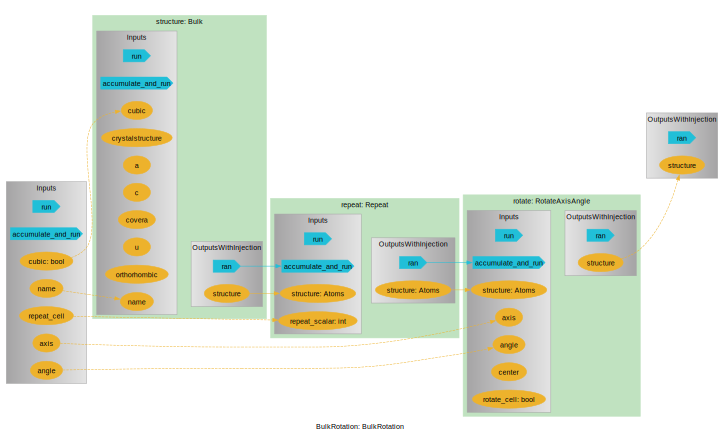

In [9]:
br.draw(size=(10, 10))

In [10]:
from pyiron_workflow.node_library.atomistic.property.phonons import GenerateSupercellsParameters

### Create phonopy workflow macro

Select input and output parameters in which users may be particularly interested, i.e., over which you want to do a parameter study (input) and the quantities you want to analyse (output)

In [11]:
@Workflow.wrap.as_macro_node(
    "imaginary_modes",
    "total_dos",
    "energy_relaxed",
    "energy_initial",
    "energy_displaced",
)
def RunPhonopy(
    wf,
    element: str,
    cell_size: int = 2,
    vacancy_index: int | None = None,
    displacement: float = 0.01,
):

    # wf.engine = wf.create.engine.ase.M3GNet()
    wf.engine = wf.create.atomistic.engine.ase.EMT()
    
    wf.structure = wf.create.atomistic.structure.build.CubicBulkCell(
        element=element, 
        cell_size=cell_size,
        vacancy_index=vacancy_index
    )
    wf.relaxed_structure = wf.create.atomistic.calculator.ase.Minimize(
        atoms=wf.structure,
        engine=wf.engine,
    )
    
    # Dataclass node access is awkward -- rethink altering the name
    wf.phonopy_input = Workflow.create.transformer.dataclass_node(
        GenerateSupercellsParameters,
        distance=displacement
    )

    wf.phonopy = wf.create.atomistic.property.phonons.CreatePhonopy(
        structure=wf.relaxed_structure.outputs.structure,
        generate_supercells_parameters=wf.phonopy_input,
        engine=wf.engine,
    )

    wf.check_consistency = wf.create.atomistic.property.phonons.CheckConsistency(
        phonopy=wf.phonopy.outputs.phonopy
    )
    wf.total_dos = wf.create.atomistic.property.phonons.GetTotalDos(
        phonopy=wf.phonopy.outputs.phonopy
    )

    wf.energies = Workflow.create.atomistic.property.phonons.DictsToList(
        wf.phonopy.outputs.df["out"],
        "energy"
    )
    # control the amount of output via log_level

    return (
        wf.check_consistency,
        wf.total_dos,
        wf.relaxed_structure.outputs.out.final.energy,
        wf.relaxed_structure.outputs.out.initial.energy,
        wf.energies,
    )

#### Run for a single parameter set

In [12]:
%%time
wf = RunPhonopy(element='Al', cell_size=3, vacancy_index=0, displacement=0.1)

CPU times: user 241 ms, sys: 101 ms, total: 342 ms
Wall time: 351 ms


In [13]:
%%time
out = wf.run()

CPU times: user 14.3 s, sys: 1 s, total: 15.4 s
Wall time: 9.54 s


/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/node_library/atomistic/property/phonons.py:129: UserWarning: WARNING: 3 imaginary modes exist
  warnings.warn(f"WARNING: {n_imaginary_nodes} imaginary modes exist")


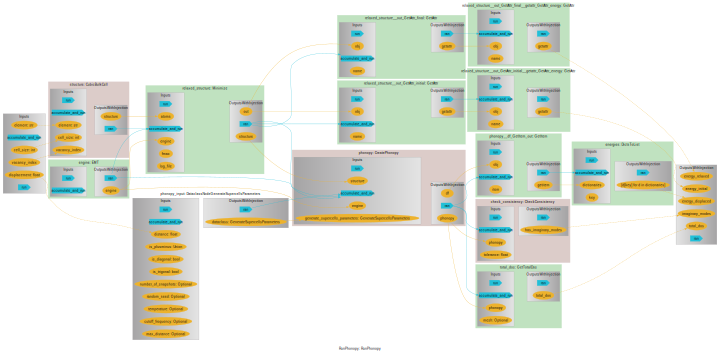

In [14]:
wf.draw(size=(10, 10))

In [15]:
import pandas as pd

In [16]:
wf.phonopy.outputs.df.value

,atoms,out
0,"(Atom('Al', [12.220710678118651, 2.08210908380...","{'energy_pot': None, 'force': None, 'stress': ..."
1,"(Atom('Al', [12.079289321881344, 1.94068772756...","{'energy_pot': None, 'force': None, 'stress': ..."
2,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
3,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
4,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
5,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
6,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
7,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
8,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."
9,"(Atom('Al', [12.149999999999997, 2.01139840568...","{'energy_pot': None, 'force': None, 'stress': ..."


#### Run iteratively over several input parameters and construct a pandas table

In [17]:
%%time
df = wf.iter(
    cell_size=list(range(1,4)), 
    # element= [Al, Cu, Pd, Ag, Pt, Au]  # Takes about a minute without looping over species
    vacancy_index=[None, 0], 
    displacement=[0.01, 0.1],
) 

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/node_library/atomistic/property/phonons.py:129: UserWarning: WARNING: 3 imaginary modes exist
  warnings.warn(f"WARNING: {n_imaginary_nodes} imaginary modes exist")


CPU times: user 1min 2s, sys: 23.8 s, total: 1min 25s
Wall time: 56.5 s


In [18]:
df

,cell_size,vacancy_index,displacement,imaginary_modes,total_dos,energy_relaxed,energy_initial,energy_displaced
0,1,NaN,0.01,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,[-0.005842915427074047]
1,1,NaN,0.10,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,[0.010553270429960904]
2,1,0.0,0.01,True,frequency_points total_dos 0 ...,0.871288,0.871288,[0.8714080922708654]
3,1,0.0,0.10,True,frequency_points total_dos 0 ...,0.871288,0.871288,[0.8833706262545284]
4,2,NaN,0.01,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,[-0.04790513998490198]
5,2,NaN,0.10,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,[-0.03199460815804045]
6,2,0.0,0.01,True,frequency_points total_dos 0 -...,0.918605,0.917941,"[0.9187758684410561, 0.918735616401376, 0.9187..."
7,2,0.0,0.10,True,frequency_points total_dos 0 -...,0.918605,0.917941,"[0.9339528274357036, 0.9336300229312133, 0.935..."
8,3,NaN,0.01,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,[-0.16206075641027518]
9,3,NaN,0.10,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,[-0.14615021022018482]


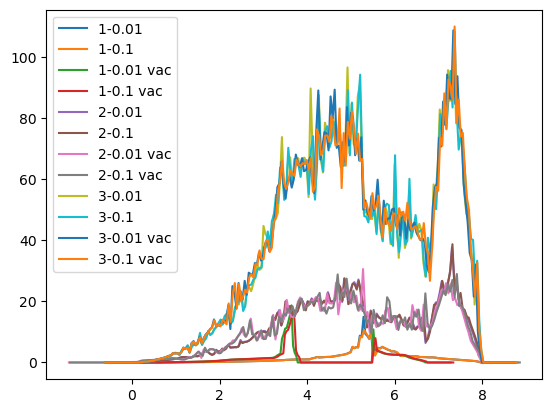

In [19]:
for size, displacement, vacancy, total_dos in zip(
    df["cell_size"], df["displacement"], df["vacancy_index"], df["total_dos"]
):
    plt.plot(
        total_dos["frequency_points"], 
        total_dos["total_dos"],
        label=f"{size}-{displacement} {'vac' if vacancy == 0 else ''}"
    )
plt.legend()
plt.show()

### Elasticity

In [20]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

import matplotlib.pylab as plt
import numpy as np

CPU times: user 2.51 ms, sys: 80 µs, total: 2.59 ms
Wall time: 2.7 ms


In [21]:
%time
wf = Workflow('phonopy')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')
wf.register('pyiron_workflow.node_library.databases', domain='databases')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [95]:
# # Get the source data
# # from Ref. de Jong et al. https://www.nature.com/articles/sdata20159#MOESM77

import requests

url = 'https://datadryad.org/stash/downloads/file_stream/88988'
destination_file = 'ec.json'

response = requests.get(url)
if response.status_code == 200:
    with open(destination_file, 'wb') as f:
        f.write(response.content)
    print('File downloaded successfully')
else:
    print('Failed to download file:', response.status_code)

# The link works fine, but downloading via python yields a 403
# I guess they are blocking scraping. 
# The file is multiple MB and I don't want to add it to the repo
# This section will no longer get automated testing
import os
SOURCE_DATA_PRESENT = os.path.exists(destination_file)

Failed to download file: 403


In [23]:
if SOURCE_DATA_PRESENT:
    wf = Workflow('elastic')
    wf.data = wf.create.databases.elasticity.DeJong()

In [24]:
%%time
if SOURCE_DATA_PRESENT:
    df_data = wf.run()['data__dataframe']

CPU times: user 5.88 s, sys: 168 ms, total: 6.04 s
Wall time: 6.07 s


In [25]:
if SOURCE_DATA_PRESENT:
    df_data

,G_Reuss,G_VRH,G_Voigt,K_Reuss,K_VRH,K_Voigt,compliance_tensor,elastic_anisotropy,elastic_tensor,elastic_tensor_original,formula,kpoint_density,material_id,nsites,poisson_ratio,poscar,space_group,structure,volume,atoms
0,96.844535,97.141604,97.438674,194.267623,194.268884,194.270146,"[[0.004385293093993, -0.0016070693558990002, -...",0.030688,"[[311.33514638650246, 144.45092552856926, 126....","[[311.33514638650246, 144.45092552856926, 126....",Nb4CoSi,7000,mp-10003,12,0.285701,Nb8 Co2 Si2\n1.0\n6.221780 0.000000 0.000000\n...,124,#\#CIF1.1\n###################################...,194.419802,"(Atom('Nb', [0.94814320435623, 2.0728045157580..."
1,93.939650,96.252006,98.564362,173.647763,175.449907,177.252050,"[[0.0037715428949660003, -0.000844229828709, -...",0.266910,"[[306.93357350984974, 88.02634955100905, 105.6...","[[306.93357350984974, 88.02634955100905, 105.6...",Al(CoSi)2,7000,mp-10010,5,0.268105,Al1 Co2 Si2\n1.0\n3.932782 0.000000 0.000000\n...,164,#\#CIF1.1\n###################################...,61.987320,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('C..."
2,120.962289,130.112955,139.263621,295.077545,295.077545,295.077545,"[[0.0019959391925840004, -0.000433146670736000...",0.756489,"[[569.5291276937579, 157.8517489654999, 157.85...","[[569.5291276937579, 157.8517489654999, 157.85...",SiOs,7000,mp-10015,2,0.307780,Si1 Os1\n1.0\n2.960692 0.000000 0.000000\n0.00...,221,#\#CIF1.1\n###################################...,25.952539,"(Atom('Si', [1.4803461749999998, 1.48034617499..."
3,12.205989,15.101901,17.997812,49.025963,49.130670,49.235377,"[[0.021647143908635, -0.005207263618160001, -0...",2.376805,"[[69.28798774976904, 34.7875015216915, 37.3877...","[[70.13259066665267, 40.60474945058445, 37.387...",Ga,7000,mp-10021,4,0.360593,Ga4\n1.0\n2.803229 0.000000 0.000000\n0.000000...,63,#\#CIF1.1\n###################################...,76.721433,"(Atom('Ga', [0.0, 1.09045796233546, 0.84078379..."
4,100.110773,101.947798,103.784823,255.055257,256.768081,258.480904,"[[0.00410214297725, -0.001272204332729, -0.001...",0.196930,"[[349.3767766177825, 186.67131003104407, 176.4...","[[407.4791016459293, 176.4759188081947, 213.83...",SiRu2,7000,mp-10025,12,0.324682,Si4 Ru8\n1.0\n4.037706 0.000000 0.000000\n0.00...,62,#\#CIF1.1\n###################################...,160.300999,"(Atom('Si', [1.0094264625, 4.247717077057611, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,43.697362,53.329789,62.962216,110.397752,111.788114,113.178476,"[[0.0044568832753350005, -0.001136458158149, -...",2.229538,"[[250.07723993082595, 71.61036453717465, 44.31...","[[250.07723993082595, 71.61036453717465, 44.31...",Ti2CdC,7000,mp-9961,8,0.294196,Ti4 Cd2 C2\n1.0\n3.103427 0.000000 0.000000\n-...,194,#\#CIF1.1\n###################################...,121.520152,"(Atom('Ti', [1.5517152117138744, 0.89588144411..."
1177,66.067578,70.253182,74.438787,101.207608,101.326807,101.446005,"[[0.007188192080993001, -0.000983458215036, -0...",0.635889,"[[172.01931871370775, 43.38593006033102, 76.22...","[[172.01931871370775, 43.38593006033102, 76.22...",ScSi,7000,mp-9969,8,0.218412,Sc4 Si4\n1.0\n3.996960 0.000000 0.000000\n0.00...,63,#\#CIF1.1\n###################################...,145.392095,"(Atom('Sc', [0.0, 8.534175787117318, 0.9174096..."
1178,62.326766,65.160458,67.994149,89.416354,89.418161,89.419968,"[[0.007749056578454001, -0.001293580144074, -0...",0.454691,"[[159.44792354820547, 42.19645554837514, 66.58...","[[159.44792354820547, 42.19645554837514, 66.58...",YSi,7000,mp-9972,8,0.206850,Y4 Si4\n1.0\n4.286685 0.000000 0.000000\n0.000...,63,#\#CIF1.1\n###################################...,174.123748,"(Atom('Y', [0.0, 9.084548591046719, 0.96092093..."
1179,37.457129,40.211802,42.966475,99.383115,99.384565,99.386015,"[[0.007456839159427001, -0.002592061077082, -0...",0.735449,"[[170.12510286354689, 70.6116049091726, 57.026...","[[170.12510286354689, 70.6116049091726, 57.026...",Al2Cu,7000,mp-998,12,0.321738,Al8 Cu4\n1.0

In [26]:
if SOURCE_DATA_PRESENT:
    unaries = df_data[df_data.formula.str.len() == 2]
    K_Reuss = unaries.K_Reuss.values
    K_Voigt = unaries.K_Voigt
    structures = unaries.atoms.values

Note: 
- Different symbols/terms for identical physical quantities would be a nice example for application of ontology
- ChatGPT could be used to analyze data (where is agreement good, where not)

In [27]:
if SOURCE_DATA_PRESENT:
    table_M3GNet = Workflow.create.atomistic.structure.calc.Volume().iter(
        structure=structures.tolist(),
    )  # TODO: load rather than run

In [28]:
if SOURCE_DATA_PRESENT:
    table_M3GNet["volume"]

0      76.721433
1      58.258386
2      73.918650
3      40.523308
4      43.685532
         ...    
62     15.850527
63     23.161980
64     45.915955
65    107.690974
66     43.223810
Name: volume, Length: 67, dtype: float64

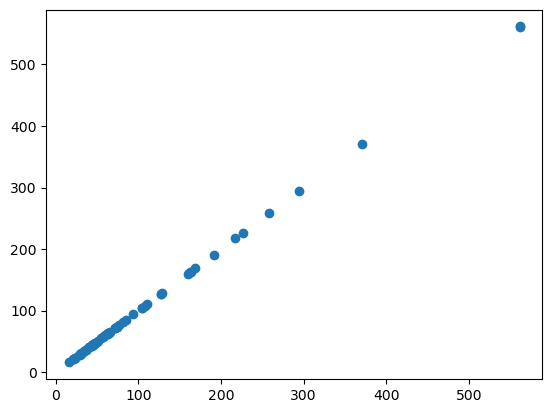

In [29]:
if SOURCE_DATA_PRESENT:
    plt.scatter(unaries["volume"], table_M3GNet["volume"]);

In [30]:
try:
    import matgl
    MATGL_PRESENT = SOURCE_DATA_PRESENT
    # We also leverage the data from above, so we need that too
except ModuleNotFoundError:
    MATGL_PRESENT = False

In [31]:
if MATGL_PRESENT:
    import warnings
    warnings.filterwarnings("ignore")

    out = Workflow.create.atomistic.property.elastic.elastic_constants().iter(structure=structures)

In [32]:
if MATGL_PRESENT:
    x = np.linspace(0, 500, 101)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(out.BR, unaries.K_Reuss)
    plt.scatter(out.BV, unaries.K_Voigt, c='g', marker = 'x')
    plt.xlabel('$B_{Reuss}$ (M3GNet)')
    plt.ylabel('$B_{Reuss}$ (DFT)')
    plt.title('Bulk Modulus')
    plt.plot(x, x, 'k--');

    plt.subplot(1,2,2)
    x = np.linspace(0, 300, 101)

    plt.scatter(out.GR, unaries.G_Reuss)
    plt.scatter(out.GV, unaries.G_Voigt, c='g', marker = 'x')
    plt.xlabel('$G_{Reuss}$ (M3GNet)')
    plt.ylabel('$G_{Reuss}$ (DFT)')
    plt.title('Shear Modulus')
    plt.plot(x, x, 'k--');

In [33]:
if MATGL_PRESENT:
    unaries.keys()

### Test universal ML potential

In [34]:
if MATGL_PRESENT:
    from ase import units
    from ase.build import bulk
    from atomistics.calculators import calc_molecular_dynamics_langevin_with_ase

In [35]:
if MATGL_PRESENT:
    import matgl
    from matgl.ext.ase import M3GNetCalculator

In [36]:
if MATGL_PRESENT:

    structure = bulk("Al", cubic=True).repeat([3, 3, 3])
    ase_calculator = M3GNetCalculator(matgl.load_model("M3GNet-MP-2021.2.8-PES"))
    result_dict = calc_molecular_dynamics_langevin_with_ase(
        structure=structure,
        ase_calculator=ase_calculator,
        run=1000,
        thermo=10,
        timestep=1 * units.fs,
        temperature=1000,
        friction=0.002,
    )

In [37]:
if MATGL_PRESENT:
    result_dict.keys()

In [38]:
if MATGL_PRESENT:
    plt.plot(result_dict['energy_pot']);

In [39]:
if MATGL_PRESENT:
    plt.plot(result_dict['positions'][:,:,0]);

In [40]:
# from pyiron_workflow.node_library.dev_tools import Output
# Does not exist in repo

In [41]:
# # Example usage:
# def get_energy(arg1, arg2):
#     #print(f"Function 1 called with arguments: {arg1}, {arg2}")
#     return arg1 + arg2

# def function2(arg1, arg2):
#     print(f"Function 2 called with arguments: {arg1}, {arg2}")
#     return f"Hello, {arg1} {arg2}!"

# def function3(arg):
#     print(f"Function 3 called with argument: {arg}")
#     return [i for i in range(arg)]

# def to_dict(func, args=(), kwargs={}):
#     return (func, args, kwargs)

# output = Output(keys_to_run=['energy'])
# print ('keys to run: ', output._keys_to_run)
# output['energy'] = to_dict(get_energy, args=(3, 2))

# output.run()

# # Iterating over keys and values
# for key, value in output.items():
#     print(f"{key}: {value}")

In [42]:
# 'energy' in output._functions

In [43]:
# func, args, kwargs = output._functions['energy']

In [44]:
# func, args, kwargs = to_dict(get_energy, args=(3, 2))

In [45]:
# func(*args)

In [46]:
# output._functions['energy']

In [47]:
# func(*args, **kwargs)

In [48]:
class LazyDict:
    def __init__(self, **kwargs):
        self._functions = {key: (value['func'], value.get('args', ()), value.get('kwargs', {})) for key, value in kwargs.items()}

    def __getitem__(self, key):
        if key not in self._functions:
            raise KeyError(f"Key '{key}' not found.")
        func, args, kwargs = self._functions[key]
        return func(*args, **kwargs)

    def __setitem__(self, key, value):
        func, args, kwargs = value
        self._functions[key] = (func, args, kwargs)

    def __delitem__(self, key):
        if key in self._functions:
            del self._functions[key]

    def keys(self):
        return list(self._functions.keys())

    def values(self):
        return [self[key] for key in self.keys()]

    def items(self):
        return [(key, self[key]) for key in self.keys()]

    def run(self, keys_to_run):
        for key in keys_to_run:
            if key in self._functions:
                self[key]

# Example usage:
def function1(arg1, arg2):
    print(f"Function 1 called with arguments: {arg1}, {arg2}")
    return arg1 + arg2

def function2(arg1, arg2):
    print(f"Function 2 called with arguments: {arg1}, {arg2}")
    return f"Hello, {arg1} {arg2}!"

def function3(arg):
    print(f"Function 3 called with argument: {arg}")
    return [i for i in range(arg)]

lazy_dict = LazyDict(
    key1={'func': function1, 'args': (3, 4), 'kwargs': {}},
    key2={'func': function2, 'args': ('John', 'Doe'), 'kwargs': {}},
    key3={'func': function3, 'args': (5,), 'kwargs': {}},
)

# Accessing values triggers function evaluation with arguments
print(lazy_dict['key1'])  # Output: Function 1 called with arguments: 3, 4 7
print(lazy_dict['key2'])  # Output: Function 2 called with arguments: John, Doe Hello, John Doe!
print(lazy_dict['key3'])  # Output: Function 3 called with argument: 5 [0, 1, 2, 3, 4]

# Adding a new key-value pair with arguments
#lazy_dict['key4'] = (lambda x, y: x * y, (2, 3), {})
lazy_dict['key4'] = (function1,  (3, 4),  {})
print(lazy_dict['key4'])  # Output: 6

# Run specific functions
lazy_dict.run(['key1', 'key2'])
# Output:
# Function 1 called with arguments: 3, 4
# Function 2 called with arguments: John, Doe

# Iterating over keys and values
for key, value in lazy_dict.items():
    print(f"{key}: {value}")

Function 1 called with arguments: 3, 4
7
Function 2 called with arguments: John, Doe
Hello, John Doe!
Function 3 called with argument: 5
[0, 1, 2, 3, 4]
Function 1 called with arguments: 3, 4
7
Function 1 called with arguments: 3, 4
Function 2 called with arguments: John, Doe
Function 1 called with arguments: 3, 4
Function 2 called with arguments: John, Doe
Function 3 called with argument: 5
Function 1 called with arguments: 3, 4
key1: 7
key2: Hello, John Doe!
key3: [0, 1, 2, 3, 4]
key4: 7


In [49]:
from phonopy.api_phonopy import Phonopy
from pyiron_workflow.node_library.dev_tools import wf_data_class

from typing import Optional, Union

In [50]:
@wf_data_class(doc_func=Phonopy.generate_displacements)
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None    

In [51]:
par = InputPhonopyGenerateSupercells(max_distance=10)
par['distance'] = 1

In [52]:
par

InputPhonopyGenerateSupercells(distance=1, is_plusminus='auto', is_diagonal=True, is_trigonal=False, number_of_snapshots=None, random_seed=None, temperature=None, cutoff_frequency=None, max_distance=10)

In [53]:
par.distance

1

In [54]:
par??

Type:        InputPhonopyGenerateSupercells
String form: InputPhonopyGenerateSupercells(distance=1, is_plusminus='auto', is_diagonal=True, is_trigonal=False, number_of_snapshots=None, random_seed=None, temperature=None, cutoff_frequency=None, max_distance=10)
Docstring:  
Generate displacement dataset.

There are two modes, finite difference method with systematic
displacements and fitting approach between arbitrary displacements and
their forces. The default approach is the finite difference method that
is built-in phonopy. The fitting approach requires external force
constant calculator.

The random displacement supercells are created by setting positive
integer values 'number_of_snapshots' keyword argument. Unless this is
specified, systematic displacements are created for the finite
difference method as the default behaviour.

Parameters
----------
distance : float, optional
    Displacement distance. Unit is the same as that used for crystal
    structure. Default is 0.01. For ran

In [55]:
par.distances=0.2

In [56]:
par.select(keys_to_store=['distance'])

{'distance': 1}

In [57]:
def test(**kwargs):
    for a in kwargs.items():
        print (a)

In [58]:
test(**par.select(keys_to_store=['distance']))

('distance', 1)


In [59]:
test(**par)

('distance', 1)
('is_plusminus', 'auto')
('is_diagonal', True)
('is_trigonal', False)
('number_of_snapshots', None)
('random_seed', None)
('temperature', None)
('cutoff_frequency', None)
('max_distance', 10)
('distances', 0.2)


In [60]:
from ase import Atoms, build

In [61]:
Al = build.bulk('Al', cubic=True)
Al.get_positions(wrap=True)

array([[0.   , 0.   , 0.   ],
       [0.   , 2.025, 2.025],
       [2.025, 0.   , 2.025],
       [2.025, 2.025, 0.   ]])

In [62]:
# Al.get_stress()
# Al needs an ASE calculator object assigned first

In [63]:
from dataclasses import dataclass, field

@dataclass
class Address:
    street: str = ""
    city: str = ""
    zip_code: str = ""

@dataclass
class Person:
    name: str
    age: int
    address: Address = field(default_factory=Address)

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

Address(street='', city='', zip_code='')


In [64]:
from dataclasses import dataclass, field

@dataclass
class Address:
    street: str
    city: str
    zip_code: str

@dataclass
class Person:
    name: str
    age: int
    address: Address = field(default_factory=lambda: Address(street='', city='', zip_code=''))

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

Address(street='', city='', zip_code='')


### Pseudocode for output class

In [65]:
from typing import Optional, Union
from typing import Callable, TypeVar, Any, TypeAlias
from dataclasses import dataclass

import numpy as np

In [66]:
@dataclass
class VarFunc:
    func: Callable = None
    log_level: int = 0
    unit: str = ''

In [67]:
@dataclass
class VarType:
    property: TypeVar = None
    log_level: int = 0
    unit: str = ''

In [68]:
VarFunc(func=np.sin, log_level=2).func

<ufunc 'sin'>

In [69]:
class toy_job:
    def __init__(self, x=0):
        self.x = x

    def get_energy(self):
        return np.sin(self.x)

    def get_forces(self):
        return np.ones(3)

    @property
    def my_x(self):
        return self.x

In [70]:
job = toy_job(1)
job.get_energy(), job.get_forces()

(0.8414709848078965, array([1., 1., 1.]))

In [71]:
@dataclass
class wfOutput:
    pass

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict       

In [72]:
import pint
ureg = pint.UnitRegistry()
ureg.angstrom

<Unit('angstrom')>

In [73]:
# import ase
import pint

@dataclass
class OutputEnergyStatic:
    distance: float = 0.01
    energy: VarFunc = field(
        default_factory=lambda: VarFunc(func=toy_job.get_energy, log_level=0, unit=ureg.eV)
    )
    forces: VarFunc = field(
        default_factory=lambda: VarFunc(func=toy_job.get_forces, log_level=1, unit=ureg.eV/ureg.angstrom)
    )
    prop: VarType = field(default_factory=lambda: VarType(toy_job.my_x, log_level=2))

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict 

### Parallel pooling

In [74]:
@Workflow.wrap.as_function_node("sleep_time", "a_out", "b_out")
def Sleep(time=1, a=None, b=10):
    from time import sleep
    
    sleep(time) 
    return time, a, b

In [75]:
import inspect

print(inspect.getsource(Sleep.node_function))

@Workflow.wrap.as_function_node("sleep_time", "a_out", "b_out")
def Sleep(time=1, a=None, b=10):
    from time import sleep
    
    sleep(time) 
    return time, a, b



In [76]:
%%time
with Workflow.create.Executor(max_cores=4) as exe:
    df = Sleep().iter(a=[1,2,3,4,5])

CPU times: user 262 ms, sys: 291 ms, total: 554 ms
Wall time: 5.65 s


In [77]:
df

,a,sleep_time,a_out,b_out
0,1,1,1,10
1,2,1,2,10
2,3,1,3,10
3,4,1,4,10
4,5,1,5,10


In [78]:
%%time
from pyiron_workflow.node_library.atomistic.engine.lammps import Code

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 14.1 µs


In [79]:
%config IPCompleter.evaluation='unsafe'

from pyiron_workflow import Workflow
import numpy as np

In [80]:
wf = Workflow('test')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')

In [81]:
@Workflow.wrap.as_macro_node('energy_pot')
def EnergyAtVolume(wf, element='Al', cell_size=2, strain=0):

    wf.structure = wf.create.atomistic.structure.build.CubicBulkCell(
        element=element, 
        cell_size=cell_size
    )
    wf.apply_strain = wf.create.atomistic.structure.transform.ApplyStrain(
        structure=wf.structure, 
        strain=strain
    )
#     # atomistic.engine.lammps.Code takes a calculator
#     # atomistic.calculator.generic.Static takes an engine
#     # So we can't pass them to each other without trouble:
#     wf.engine = wf.create.atomistic.engine.lammps.Code(
#         structure=wf.apply_strain
#     )
#     wf.calc = wf.create.atomistic.calculator.generic.Static(
#         structure=wf.apply_strain, 
#         engine=wf.engine
#     )
    
#     return wf.calc.outputs.generic.energy_pot

    # Instead we can just use the lammps node directly,
    # whose `calculator` is anyhow defaulting to InputCalcStatic()
    wf.calc = wf.create.atomistic.engine.lammps.Code(
        structure=wf.apply_strain
    )
    return wf.calc.outputs.generic.energy_pot

In [82]:
df = EnergyAtVolume(element='Fe').iter(strain=np.linspace(-0.2, 0.2, 11).tolist())

/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/pymatgen/io/lammps/outputs.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO("\n".join(lines[9:])), names=data_head, delim_whitespace=True)
/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/pymatgen/io/lammps/outputs.py:183: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO("".join(lines)), delim_whitespace=True)
/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/pymatgen/io/lammps/outputs.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO("\n".join(lines[9:])), names=data_head, delim_whitespace=True)
/Users/huber/

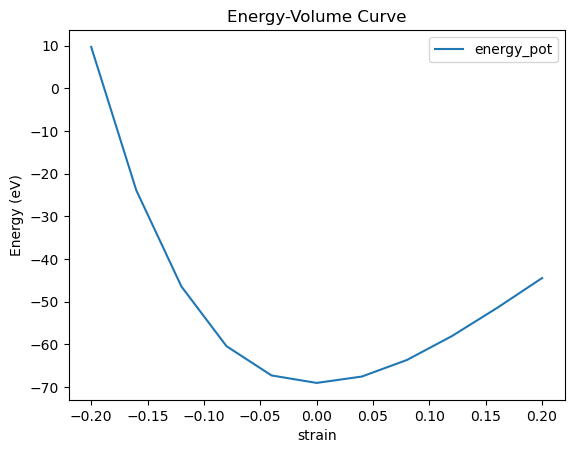

In [83]:
df.plot(x='strain', ylabel='Energy (eV)', title='Energy-Volume Curve');

In [84]:
wf = Workflow('test')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')
wf.structure = wf.create.atomistic.structure.build.Bulk('Al')
wf.engine = wf.create.atomistic.engine.lammps.Code(structure=wf.structure)  # TODO: find a way to avoid structure=wf.structure !
# wf.calc = wf.create.atomistic.calculator.generic.static(structure=wf.structure, engine=wf.engine)

wf.run()

/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/pymatgen/io/lammps/outputs.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO("\n".join(lines[9:])), names=data_head, delim_whitespace=True)
/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/pymatgen/io/lammps/outputs.py:183: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO("".join(lines)), delim_whitespace=True)


{'engine__generic': OutputCalcStatic(energy_pot=-3.35999999707241, force=array([[5.55111512e-17, 1.52655666e-16, 1.52655666e-16]]), stress=None, structure=None, atomic_energies=None)}

In [85]:
# wf.calc.outputs.generic.value.energy_pot
wf.engine.outputs.generic.value.energy_pot

-3.35999999707241

In [86]:
wf.engine.outputs.generic.value

OutputCalcStatic(energy_pot=-3.35999999707241, force=array([[5.55111512e-17, 1.52655666e-16, 1.52655666e-16]]), stress=None, structure=None, atomic_energies=None)

In [87]:
# wf.calc

In [88]:
# wf.calc.outputs.generic.value.energy_pot

In [89]:
%%time
from pyiron_workflow.node_library.atomistic.calculator.data import InputCalcMinimize, InputCalcStatic

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 28.8 µs


In [90]:
%%time
from pyiron_atomistics.lammps.base import LammpsControl

CPU times: user 5.67 ms, sys: 4.59 ms, total: 10.3 ms
Wall time: 9.81 ms


In [91]:
InputCalcMinimize(), InputCalcStatic()

(InputCalcMinimize(e_tol=0.0, f_tol=0.0001, max_iter=1000000, pressure=None, n_print=100, style='cg'),
 InputCalcStatic())

In [92]:
from pyiron_atomistics.lammps.control import LammpsControl

In [93]:
# LammpsControl._mode  # We add this attribute in the input control nodes